In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
first = session.query(measurement).first()
first.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x146cdb700>,
 'station': 'USC00519397',
 'date': '2010-01-01',
 'tobs': 65.0,
 'prcp': 0.08,
 'id': 1}

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
session.query(measurement.date).order_by(measurement.date.desc()).first()


('2017-08-23',)

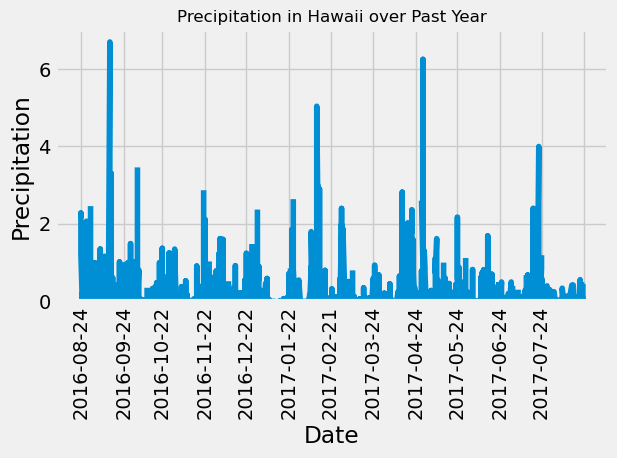

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent = dt.date(2017, 8, 23)

# Calculate the date one year from the last date in data set.
start_date = (most_recent - dt.timedelta(days=365)).strftime("%Y-%m-%d")

# Perform a query to retrieve the data and precipitation scores
prcp_scores = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date > start_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df = pd.DataFrame(prcp_scores, columns=["Date", "Precipitation"])

# Sort the dataframe by date
sorted_prcp_df = prcp_df.sort_values("Date")

# Use Pandas Plotting with Matplotlib to plot the data
import matplotlib.dates as mdates  
from matplotlib.axis import Axis

style.use('fivethirtyeight')
fig, ax = plt.subplots()
ax.plot("Date", "Precipitation", data = sorted_prcp_df, label="Precipitation")
Axis.set_major_locator(ax.xaxis, mdates.MonthLocator())

plt.xticks(rotation="vertical")
plt.ylabel("Precipitation")
plt.xlabel("Date")
plt.ylim(0,7)
plt.title("Precipitation in Hawaii over Past Year", fontsize=12)
plt.tight_layout()
plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
sorted_prcp_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
first.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x146cdb700>,
 'station': 'USC00519397',
 'date': '2010-01-01',
 'tobs': 65.0,
 'prcp': 0.08,
 'id': 1}

In [14]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(measurement.station)).all()

[(19550,)]

In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_station = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).first()

active_station[0]

'USC00519281'

In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temps = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
    filter(measurement.station == active_station[0]).first()

temps

(54.0, 85.0, 71.66378066378067)

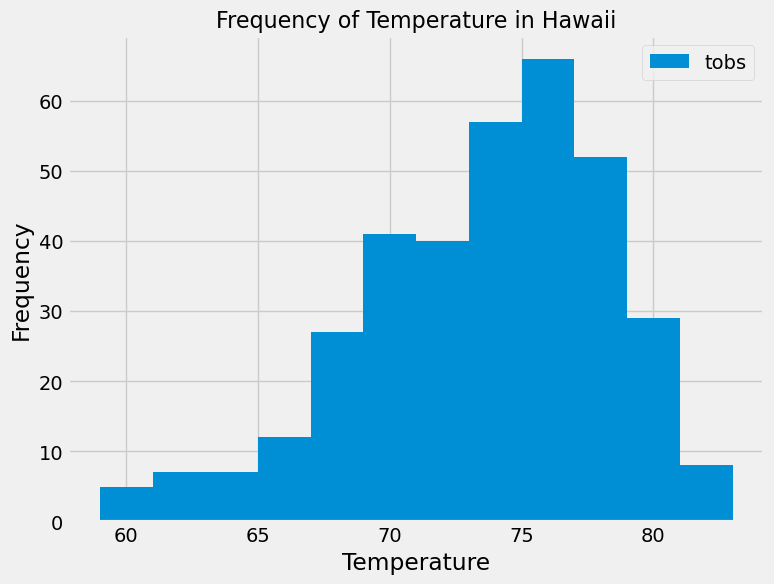

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs = session.query(measurement.tobs).\
    filter(measurement.station == active_station[0]).\
    filter(measurement.date > start_date).all()

tobs_df = pd.DataFrame(tobs, columns=["tobs"])

style.use('fivethirtyeight')
plt.figure(figsize=(8,6))
plt.hist(tobs_df, bins=12, label="tobs")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title("Frequency of Temperature in Hawaii", fontsize = 16)
plt.legend()
plt.show()

# Close Session

In [18]:
# Close Session
session.close()